**Hausaufgabe 3**
1.   Daten finden - z.B. Kaggle (Bilder oder tabular)
2.   Train/Validation/Test split (Validation und Test - kein Shuffle) - sklearn oder manuell
3. Beim Training - loss etc auf beiden berechen (Train und Valid) und über Trainings-Erfolg anhand von Validation set entscheiden. Testset nur zur auswertung verwenden.
4. Eigenes Early Stopping implementieren: d.h. wenn Validation Loss über n (zu definieren, z.B. 10 oder 20) iterationen nicht kleiner wurde (delta zu definieren z.B. 10^(-4)), wird das training gestoppt und das letzte model gespeichert - bitte selbst rausfinden, wie man ein torch model speichert
5. Accuracy (gerne auch Precision und Recall)
6. Model Graph plotten
7. Loss von train history plotten (weitere sinnvolle plots willkommen)


**Homework 3**

1.   Find data - e.g. Kaggle (images or tabular)
2. Train/Validation/Test split (validation and test - no shuffle) - sklearn or manual
3. When training - calculate loss etc on both (train and valid) and decide on training success based on validation set. Use test set only for evaluation.
4. Implement your own early stopping: i.e. if validation loss has not decreased over n (to be defined, e.g. 10 or 20) iterations (delta to be defined, e.g. 10^(-4)), training is stopped and the last model is saved - please find out for yourself how to save a torch model
5. Accuracy (also precision and recall)
6. Plot model graph
7. Plot loss from train history (other useful plots welcome)

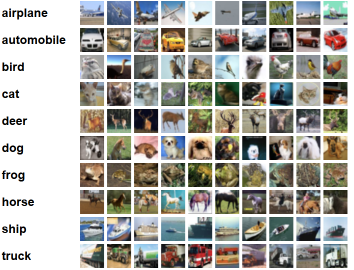

In [1]:
# We need to be able to convert the data for the images back into something useful
import pickle # for serializing and deserializing objects. In simpler terms, it allows you to convert a Python object into a byte stream (so you can save it to a file or send it over a network) and then convert that byte stream back into a Python object.
# Useful maths functions
import numpy as np # add support for N-dimensional arrays, standard maths functions, linear algebra and all the stuff you sort of remember from school
# Pytorch is what this course seems to be about so lets have that one too
import torch
# DataLoader: efficient way to iterate over datasets in batches. Also supports shuffling and multithreading
# Dataset: abstract class for creating ones own datasets. Requires "__len__" (size of the dataset) and "__getitem__" (sample from dataset)
# TensorDataset: If you have a dataset comprised of tensors this wrapper will enable the extraction of tensors as tuples
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from torch import nn # add neural network functionality as per class instructions
from torchvision.transforms import ToTensor, Lambda # needed for some vision work... let's see if we actually need it
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.set_default_device(device)  # set the default device to be used for tensors

Using cuda device


In [3]:
# Just for test purpose... we do it on our own
'''
# Fetching the data with the built-in mechanism from pythorch, they can be also fetched from the source https://www.cs.toronto.edu/~kriz/cifar.html
# Creating the datasets for training, validation and testing
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
'''


# Fetching the data from the source https://www.cs.toronto.edu/~kriz/cifar.html
import os
import urllib.request
import tarfile
import sys
import shutil


data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
data_filename = 'cifar-10-python.tar.gz'
extracted_data_path = 'cifar-10-batches-py'
dataset_basepath = 'data'
dataset_path = dataset_basepath + '/' + extracted_data_path
dataset_path_for_loader = dataset_path + '/'

# get the current working directory... set this to a path where the files will be stored
dataset_download_path = os.getcwd()

# change the working directory to the dataset_path since the download will download it to the current working directory
os.chdir(dataset_download_path)



# Let's see what we have
print(f"dataset_download_path: {dataset_download_path}")


# fetch the file (will be saved to the current working path) if not existing
if not os.path.isfile(data_filename):
    urllib.request.urlretrieve(data_url, data_filename)


print(f"dataset_path: {dataset_path}")

# delete a files and all subdirectories! For testing purpose
#shutil.rmtree(dataset_basepath)

# extract the files if not already existing
if not os.path.isdir(dataset_path):
    with tarfile.open(data_filename, 'r:gz') as tar:
        tar.extractall(path=dataset_basepath)

# List files and directories
files = os.listdir(dataset_basepath)
print(f"files and directories in {dataset_basepath}: {files}")
files = os.listdir(dataset_path)
print(f"files and directories in {dataset_path}: {files}")

# make sure we have some files or directories
if not os.listdir(dataset_path + "/"):
    sys.exit("Witout files or directories it is useless to proceed")

dataset_download_path: g:\Meine Ablage\Colab Notebooks
dataset_path: data/cifar-10-batches-py
files and directories in data: ['cifar-10-batches-py']
files and directories in data/cifar-10-batches-py: ['data_batch_4', 'readme.html', 'test_batch', 'data_batch_3', 'batches.meta', 'data_batch_2', 'data_batch_5', 'data_batch_1']


In [4]:
# Path to the extracted files
DATA_PATH = dataset_path_for_loader

# Load a single batch file
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']

    # Reshape the data to the (num_samples, 3, 32, 32) format
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize to [0, 1]
    labels = np.array(labels)

    # Convert to torch tensors
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(data_tensor, labels_tensor)

# If you look at the screen shot above, you will see that there are five equally sized data batches and one test batch.
# Load data batches 1-4 from their files
train_batches = []
for i in range(1, 4):
    train_batches.append(load_cifar_batch(f'{DATA_PATH}data_batch_{i}'))

# Combine the first four data batches into a single dataset for training
train_data = torch.utils.data.ConcatDataset(train_batches)

# Load data_batch_5 as validation set
val_data = load_cifar_batch(f'{DATA_PATH}data_batch_5')

# Load test_batch as test set
test_data = load_cifar_batch(f'{DATA_PATH}test_batch')



In [5]:
# Define batch size
batch_size = 64

# Define a starting learning rate (hopefully with an optimizer this won't be mission critical)
learning_rate = 1e-3

# Set a small number of epochs to start with
epochs = 30

# 2. Train/Validation/Test split (validation and test - no shuffle) - sklearn or manual

In [6]:
# Create DataLoader objects
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set

In [7]:
print(len(train_loader))
print(train_loader)

for X, y in train_loader:
    print(X.shape)
    break

469
torch.Size([64, 3, 32, 32])


## Sanity check of the data

In [8]:
# We should check the data look OK and that we understand exactly what we have
# Let's plot an image and the corresponding pre-defined classification
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Get the data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Extract the first image and label from the batch
# Note, this will be a different image each time you plot it because the act of calling "train_loader" will randomise the picture order
# Try running this cell multipe times and the label will change...
image = images[0]
label = labels[0].item()

# How are the labels defined in the data set?
print(label)

8


## Grrr... The label is a zero-based integer not a string...
The data can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

![image.png](attachment:a69bdc9d-d43c-4866-8a77-2d973f4be3a3.png)

Presumably "airplane" is label[0] and "truck" is label[9]
so...

In [9]:
# Define the CIFAR-10 classes for annotation
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

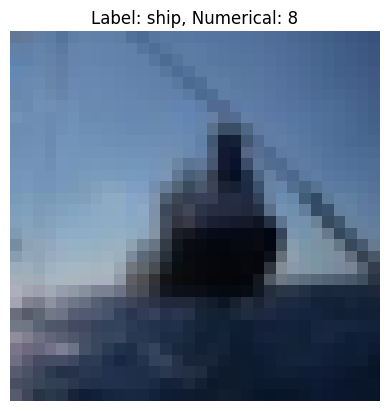

In [10]:
# Convert the image tensor to a NumPy array and transpose to (32, 32, 3) for plotting
image_np = image.cpu().permute(1, 2, 0).numpy()

# The images were normalised for the "intended use", so we need to un-normalise them for plotting
image_np = image_np * 255.0

# Display the image with its label
plt.imshow(image_np.astype("uint8"))
plt.title(f"Label: {cifar10_classes[label]}, Numerical: {label}")
plt.axis('off')
plt.show()

In [11]:
# Define model using the code from class
# ORIGINAL - do not change
class NeuralNetwork_Linear_3_ReLU(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, hidden_size1), # 28*28 replaced with 3*32*32 because that seems to be the image size of this data set
            nn.ReLU(), # ReLU makes everything that is negative zero to simulate an excititory neuron in the network
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def get_init_params(self):
        return self.hidden_size1, self.hidden_size2

In [ ]:

# Define model with SoftMax
class NeuralNetwork_Linear_3_SoftMax(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, hidden_size1), # 28*28 replaced with 3*32*32 because that seems to be the image size of this data set
            nn.Softmax(), # Softmax makes a decay to zero in the data rather than a hard cut at zero... some negatives remain according to my notes from class
            nn.Linear(hidden_size1, hidden_size2),
            nn.Softmax(),
            nn.Linear(hidden_size2, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def get_init_params(self):
        return self.hidden_size1, self.hidden_size2

In [ ]:
# Define model with Sigmoid
class NeuralNetwork_Linear_3_Sigmoid(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, hidden_size1), # 28*28 replaced with 3*32*32 because that seems to be the image size of this data set
            nn.Sigmoid(), # Sigmoid makes sure all values are between 0 and 1 with an S-shaped curve
            nn.Linear(hidden_size1, hidden_size2),
            nn.Sigmoid(),
            nn.Linear(hidden_size2, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def get_init_params(self):
        return self.hidden_size1, self.hidden_size2

In [14]:
class Result():
    def __init__(self):
        self.best_val_accuracy = 0 # So we can tell if the new model gets better
        self.best_pred = None # holds the best prediction to plot the model graph later
        self.epochs_used = 0 # How many epochs were used to train the model

        self.train_loss_history = []
        self.recall_history = []
        self.precision_history = []

        # Early stopping proposal is to check in each EPOCH how good the model is with the validation set
        # If the validation performs better than any previous Epoch then make the current model the best model and set the patience_counter = 0
        # If the validation performs worse than than the best model then increase the patience_counter by +1
        # If the patience_counter exceeds the patience threshhold then stop training and use the best model found with the test data set
        self.patience, self.patience_counter = 5, 0 # If the model doesn't improve relative to the best model then stop after this main epochs without improvement

        

In [15]:
class Experiment():
    def __init__(self, model, optimizer=None, scheduler=None):
        self.model = model
        if (optimizer == None):
            self.optimizer = self.create_optimizer()
        else:
            self.optimizer = optimizer
        if (scheduler == None):
            self.scheduler = self.create_scheduler()
        else:
            self.scheduler = scheduler
        self.result = Result()

    def create_optimizer(self):
        # Use ADAM as an optimizer as it seemed to perform pretty well last time
        # Maybe compare with other optimizers...
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def create_scheduler(self):
        # What is the best learning rate?
        # scheduler: This is the learning rate scheduler object that you can use to adjust the learning rate during each epoch or training step.
        # torch.optim.lr_scheduler.CosineAnnealingLR: This is a specific type of learning rate scheduler in PyTorch that decreases the learning rate following a cosine curve.
        # optimizer: This is the optimizer that the learning rate scheduler will modify. The optimizer manages the parameters and updates them based on the learning rate.
        # T_max=10: This parameter specifies the maximum number of iterations (or epochs) before the learning rate reaches its minimum value. In this case, T_max=10 means that over the course of 10 epochs, the learning rate will decrease following a cosine curve until it reaches the minimum.
        return torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10, eta_min=1e-6)

In [16]:
# Define models
# increasing the number of neurons in the hidden layers

linear_models = []
# SoftMax
linear_models.append(NeuralNetwork_Linear_3_SoftMax(512, 512).to(device))
linear_models.append(NeuralNetwork_Linear_3_SoftMax(512, 1024).to(device))
linear_models.append(NeuralNetwork_Linear_3_SoftMax(1024, 512).to(device))
# No SoftMax
linear_models.append(NeuralNetwork_Linear_3_Sigmoid(512, 512).to(device))
linear_models.append(NeuralNetwork_Linear_3_Sigmoid(512, 1024).to(device))
linear_models.append(NeuralNetwork_Linear_3_Sigmoid(1024, 512).to(device))
# ReLU
linear_models.append(NeuralNetwork_Linear_3_ReLU(512, 512).to(device))
linear_models.append(NeuralNetwork_Linear_3_ReLU(512, 1024).to(device))
linear_models.append(NeuralNetwork_Linear_3_ReLU(1024, 512).to(device))

# Initialize the loss function 
loss_fn = nn.CrossEntropyLoss() # mean absolute error , mse


# 3. When training - calculate loss etc on both (train and valid) and decide on training success based on validation set

In [17]:
# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    model_pred = None
    for X, y in dataloader: # X is the data and y the label
        X, y = X.to(device), y.to(device) # device is either CPU or GPU

        optimizer.zero_grad() # We don't want the previous gradients to contaminate the optimizer so we reset them
        model_pred = model(X) # data is passed through the model to generate a prediction of the label
        loss = loss_fn(model_pred, y) # loss_fn uses the "cross entropy" model mentioned in class to compare the predicted label (pred) with the actual lable (y). A low value is good
        # Backpropagation: Back propagation is attempting to figure out which of the weights are responsible for most of the error. It does this by calculating the error between the predicted output and actual output and then propagating this error back through the layers to find out how much each weight contributed to the error. Like tuning a radio, the learning rate comes in here and is related to how big a click the weight knob can be turned in one step up or down in order that the overall error can be reduced.
        loss.backward() # Calculate the gradients of the loss
        optimizer.step() # Tune the radio to reduce the error using Adam to estimate how much to tune it by

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss, model_pred

# Validation loop: this can be used for both the validation data during the training and the test data after the best model has been found
def validate_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0
    pred = None
    recall = None
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            y_pred = (pred.argmax(1) == 1).float()
            true_positives += ((y_pred == 1) & (y == 1)).sum().item()
            false_negatives += ((y_pred == 0) & (y == 1)).sum().item()
            false_positives += ((y_pred == 1) & (y == 0)).sum().item()

            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    recall = true_positives / (true_positives + false_negatives)
    precision = 0
    if (true_positives + false_positives) > 0:
        precision = true_positives / (true_positives + false_positives)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, pred, recall, precision

## 4. Implement your own early stopping: i.e. if validation loss has not decreased over n (to be defined, e.g. 10 or 20) iterations (delta to be defined, e.g. 10^(-4)), training is stopped and the last model is saved - please find out for yourself how to save a torch model

In [18]:
class model_exec_loop():
    def __init__(self, i, experiment):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device)) # Shuffle training set. Because of shuffle, we need to set the genrator set to the actual device
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set
        self.experiment = experiment
        
        print(f"Training model {experiment.model.__class__.__name__}_{experiment.model.get_init_params()} with hidden sizes {experiment.model.get_init_params()} \n")
        # Loop training "epochs" number of times
        for t in range(epochs):
            print(f"Epoch {t+1} for {i}\n-------------------------------")
            # Run the training from task 3
            train_loss, model_pred = train_loop(train_loader, experiment.model, loss_fn, experiment.optimizer)
            self.experiment.result.train_loss_history.append(train_loss)
            # After each attempt at training test the model against the validation set
            val_loss, val_accuracy, pred, recall, precision = validate_loop(val_loader, experiment.model, loss_fn)
            self.experiment.result.recall_history.append(recall)
            self.experiment.result.precision_history.append(precision)
            print(f"{i} Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*val_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")

            # Check for improvement and if better than before, write out the model to disk
            if val_accuracy > self.experiment.result.best_val_accuracy: # New model is better than the old model
                self.experiment.result.best_val_accuracy = val_accuracy
                self.experiment.result.best_pred = model_pred
                torch.save(experiment.model.state_dict(), f"best_model_{i}.pth")
                self.experiment.result.patience_counter = 0 # I am interested again, reset my boredom levels
                print(f"Best model saved for {i}.")
            else:
                # If the model is worse then increase the patience_counter until we give up
                self.experiment.result.patience_counter += 1 # Computer gets slightly more bored when the new model is less good than the best so far
                if self.experiment.result.patience_counter >= self.experiment.result.patience: # Boredom threshhold is past so the computer gives up as the model isn't improving
                    print(f"Early stopping triggered for {i}. Training stopped. \n")
                    break

            # Adjust learning rate
            experiment.scheduler.step() # Slightly unclear how this actually works
            print(f"Learning Rate for {i}: {experiment.scheduler.get_last_lr()[0]} \n")

# Linear Experiments

In [23]:
linear_experiments = []

In [24]:
force_linear_experiment = False
if force_linear_experiment or len(linear_experiments) == 0:
    linear_experiments = []
    for model in linear_models:
        experiment = Experiment(model)
        linear_experiments.append(experiment)
        model_exec_loop(len(linear_experiments), experiment)
        
print("All models trained")


    

Training model NeuralNetwork_Linear_3_SoftMax_(512, 512) with hidden sizes (512, 512) 

Epoch 1 for 1
-------------------------------
1 Training Loss: 2.2493, Validation Loss: 2.2484, Validation Accuracy: 17.7%, Recall: 0.0, Precision: 0
Best model saved for 1.
Learning Rate for 1: 0.0009755527298894294 

Epoch 2 for 1
-------------------------------
1 Training Loss: 2.2490, Validation Loss: 2.2472, Validation Accuracy: 17.8%, Recall: 0.0, Precision: 0
Best model saved for 1.
Learning Rate for 1: 0.0009046039886902864 

Epoch 3 for 1
-------------------------------
1 Training Loss: 2.2483, Validation Loss: 2.2478, Validation Accuracy: 17.6%, Recall: 0.0, Precision: 0
Learning Rate for 1: 0.0007940987335200905 

Epoch 4 for 1
-------------------------------
1 Training Loss: 2.2480, Validation Loss: 2.2481, Validation Accuracy: 17.4%, Recall: 0.0, Precision: 0
Learning Rate for 1: 0.0006548539886902864 

Epoch 5 for 1
-------------------------------
1 Training Loss: 2.2461, Validation Lo

In [25]:
%pip install tabulate
from tabulate import tabulate

experiments = linear_experiments

# Print the results
print("Results")
table = [['Model', 'Best Validation Accuracy', 'Recall', 'Precision', 'Epochs']]
for i, experiment in enumerate(experiments):
    best_val_accuracy = 100 * experiment.result.best_val_accuracy
    recall = experiment.result.recall_history[-1]
    precision = experiment.result.precision_history[-1]
    epochs_used = len(experiment.result.train_loss_history)
    table.append([f"{experiment.model.__class__.__name__}_{experiment.model.get_init_params()}", f"{best_val_accuracy:.2f}%", recall, precision, epochs_used])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


Note: you may need to restart the kernel to use updated packages.
Results
╒════════════════════════════════════════════╤════════════════════════════╤══════════╤═════════════╤══════════╕
│ Model                                      │ Best Validation Accuracy   │   Recall │   Precision │   Epochs │
╞════════════════════════════════════════════╪════════════════════════════╪══════════╪═════════════╪══════════╡
│ NeuralNetwork_Linear_3_SoftMax_(512, 512)  │ 17.79%                     │ 0        │    0        │        7 │
├────────────────────────────────────────────┼────────────────────────────┼──────────┼─────────────┼──────────┤
│ NeuralNetwork_Linear_3_SoftMax_(512, 1024) │ 25.23%                     │ 0.574951 │    0.847384 │       30 │
├────────────────────────────────────────────┼────────────────────────────┼──────────┼─────────────┼──────────┤
│ NeuralNetwork_Linear_3_SoftMax_(1024, 512) │ 25.61%                     │ 0.519724 │    0.854133 │       30 │
├─────────────────────────────

# Results Linear

Very low changes about the features used. 

| Model                                      | Best Validation Accuracy | Recall   | Precision | Epochs |
|--------------------------------------------|--------------------------|----------|-----------|--------|
| NeuralNetwork_Linear_3_SoftMax_(512, 512)  | 17.79%                   | 0        | 0         | 7      |
| NeuralNetwork_Linear_3_SoftMax_(512, 1024) | 25.23%                   | 0.574951 | 0.847384  | 30     |
| NeuralNetwork_Linear_3_SoftMax_(1024, 512) | 25.61%                   | 0.519724 | 0.854133  | 30     |
| NeuralNetwork_Linear_3_Sigmoid_(512, 512)  | 49.57%                   | 0.581854 | 0.916149  | 17     |
| NeuralNetwork_Linear_3_Sigmoid_(512, 1024) | 48.92%                   | 0.455621 | 0.946721  | 15     |
| NeuralNetwork_Linear_3_Sigmoid_(1024, 512) | 49.47%                   | 0.586785 | 0.926791  | 16     |
| NeuralNetwork_Linear_3_ReLU_(512, 512)     | 51.99%                   | 0.642998 | 0.935438  | 17     |
| NeuralNetwork_Linear_3_ReLU_(512, 1024)    | 50.66%                   | 0.542406 | 0.932203  | 17     |
| NeuralNetwork_Linear_3_ReLU_(1024, 512)    | 51.44%                   | 0.544379 | 0.945205  | 15     |



# Conv2D Experments (Kernel size, stride, padding)

In [272]:
import torch.nn.functional as F

class NeuralNetwork_Conv2d_Kernel(nn.Module):
    def __init__(self, kernel_size, stride, padding, kernel_size2 = 5, conv1OutputChannels = 6, conv2OutputChannels = 16, conv3OutputChannels = 0, kernel_size3 = 5):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv1OutputChannels = conv1OutputChannels
        self.conv2OutputChannels = conv2OutputChannels
        self.conv3OutputChannels = conv3OutputChannels
        self.kernel_size2 = kernel_size2
        self.kernel_size3 = kernel_size3
        self.conv1 = nn.Conv2d(3, self.conv1OutputChannels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(self.conv1OutputChannels, self.conv2OutputChannels, self.kernel_size2)
        self.conv3 = nn.Conv2d(self.conv2OutputChannels, self.conv3OutputChannels, self.kernel_size3)
        #self.fc1 = nn.Linear(16*5*5, 120)  # 16 channels * 5x5 image size
        self.fc1 = None
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if (self.conv2OutputChannels > 0):
            x = self.pool(F.relu(self.conv2(x)))
        if (self.conv3OutputChannels > 0):
            x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1_wrapper(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


    def fc1_wrapper(self, x):
        if (self.fc1 == None):
            self.fc1 = nn.Linear(x.size(dim=1), 120)  # dim 1 holds the number of features
        return self.fc1(x)

    def get_init_params(self):
        return f'1st kernel size: {self.kernel_size}, stride: {self.stride}, padding: {self.padding}, conv1OutputChannels: {self.conv1OutputChannels} - 2nd kernel size: {self.kernel_size2}, conv2OutputChannels: {self.conv2OutputChannels} - 3nd kernel size: {self.kernel_size3}, conv3OutputChannels: {self.conv3OutputChannels}' 

In [ ]:
force_conv2d_experiment = True # Set to True to force the training of the models again, set to false to skip if already computed
if force_conv2d_experiment == True:
    conv2d_experiments = [] # Reset the experiments

In [287]:
conv2d_models = []
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(2,1, 0).to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(2,1, 'same').to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(3,1, 'same').to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(3,2, 0).to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(3,2, 2).to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 0).to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same').to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(5,2, 2).to(device))
conv2d_models.append(NeuralNetwork_Conv2d_Kernel(5,2, 3).to(device))
if len(conv2d_experiments) == 0:
    for model in conv2d_models:
        experiment = Experiment(model)
        conv2d_experiments.append(experiment)
        model_exec_loop(len(conv2d_experiments), experiment)
        
print("All models trained")


Training model NeuralNetwork_Conv2d_Kernel1st kernel size: 2, stride: 1, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 with hidden sizes 1st kernel size: 2, stride: 1, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 

Epoch 1 for 1
-------------------------------
1 Training Loss: 1.9866, Validation Loss: 1.8018, Validation Accuracy: 33.9%, Recall: 0.6390532544378699, Precision: 0.8393782383419689
Best model saved for 1.
Learning Rate for 1: 0.0009755527298894294 

Epoch 2 for 1
-------------------------------
1 Training Loss: 1.7102, Validation Loss: 1.6955, Validation Accuracy: 38.7%, Recall: 0.4240631163708087, Precision: 0.8811475409836066
Best model saved for 1.
Learning Rate for 1: 0.0009046039886902864 

Epoch 3 for 1
-------------------------------
1 Training Loss: 1.6148, Validation Loss: 1.5968, Validation Accuracy: 41.7%

In [289]:
from tabulate import tabulate

#experiments = linear_experiments + conv2d_experiments
experiments = conv2d_experiments

# Print the results
print("Results")
table = [['Row','Model', 'Best Validation Accuracy', 'Recall', 'Precision', 'Epochs']]
for i, experiment in enumerate(experiments):
    best_val_accuracy = 100 * experiment.result.best_val_accuracy
    recall = experiment.result.recall_history[-1]
    precision = experiment.result.precision_history[-1]
    epochs_used = len(experiment.result.train_loss_history)
    table.append([i, f"{experiment.model.__class__.__name__}_{experiment.model.get_init_params()}", f"{best_val_accuracy:.2f}%", recall, precision, epochs_used])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Results
╒═══════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════╤══════════╤═════════════╤══════════╕
│   Row │ Model                                                                                                                                                                                       │ Best Validation Accuracy   │   Recall │   Precision │   Epochs │
╞═══════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════╪══════════╪═════════════╪══════════╡
│     0 │ NeuralNetwork_Conv2d_Kernel_1st kernel size: 2, stride: 1, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0   

# Results (Kernel size)

The results are very much the same except some low performers which are

* kernel size 2 is too small (Row 0 and 1)
* kernel size 3 with stride 2 and no padding (Row 3)

| Row | Model                                                                                                                                                                                       | Best Validation Accuracy | Recall   | Precision | Epochs |
|-----|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|----------|-----------|--------|
| 0   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 2, stride: 1, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 47.03%                   | 0.54931  | 0.881329  | 14     |
| 1   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 2, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 | 48.71%                   | 0.592702 | 0.93323   | 30     |
| 2   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 | 52.57%                   | 0.630178 | 0.906383  | 30     |
| 3   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 2, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 47.91%                   | 0.618343 | 0.891892  | 30     |
| 4   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 2, padding: 2, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 52.98%                   | 0.671598 | 0.910428  | 30     |
| 5   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: 0, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 53.28%                   | 0.642998 | 0.923513  | 30     |
| 6   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 | 53.62%                   | 0.641026 | 0.933908  | 30     |
| 7   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 2, padding: 2, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 51.48%                   | 0.659763 | 0.924033  | 30     |
| 8   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 2, padding: 3, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0    | 53.66%                   | 0.663708 | 0.934722  | 30     |

# Conv2D Experments (Output channels)

In [ ]:
force_conv2d_output_experiment = True # Set to True to force the training of the models again, set to false to skip if already computed
if force_conv2d_output_experiment == True:
    conv2d_output_experiments = [] # Reset the experiments


In [ ]:
conv2d_output_models = []
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(3,1, 'same', 3).to(device))          # 3x3 1st kernel, 1 stride, same padding,  6 output channels, 3x3 2nd kernel, 16 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(3,1, 'same', 5).to(device))          # 3x3 1st kernel, 1 stride, same padding,  6 output channels, 5x5 2nd kernel, 16 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same', 3).to(device))          # 5x5 1st kernel, 1 stride, same padding,  6 output channels, 3x3 2nd kernel, 16 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same', 5).to(device))          # 5x5 1st kernel, 1 stride, same padding,  6 output channels, 5x5 2nd kernel, 16 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same', 5, 12, 32).to(device))  # 5x5 1st kernel, 1 stride, same padding, 12 output channels, 5x5 2nd kernel, 32 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same', 5, 12, 24).to(device))  # 5x5 1st kernel, 1 stride, same padding, 12 output channels, 5x5 2nd kernel, 24 output channels
conv2d_output_models.append(NeuralNetwork_Conv2d_Kernel(5,1, 'same', 5, 8, 16).to(device))   # 5x5 1st kernel, 1 stride, same padding,  8 output channels, 5x5 2nd kernel, 16 output channels

if len(conv2d_output_experiments) == 0:
    for model in conv2d_output_models:
        experiment = Experiment(model)  # Create an experiment object for each model
        conv2d_output_experiments.append(experiment)
        model_exec_loop(len(conv2d_output_experiments), experiment)  # Train the model
        
print("All models trained")


Training model NeuralNetwork_Conv2d_Kernel1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 with hidden sizes 1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0 

Epoch 1 for 1
-------------------------------
1 Training Loss: 2.0096, Validation Loss: 1.8132, Validation Accuracy: 33.3%, Recall: 0.626232741617357, Precision: 0.8048162230671736
Best model saved for 1.
Learning Rate for 1: 0.0009755527298894294 

Epoch 2 for 1
-------------------------------
1 Training Loss: 1.7244, Validation Loss: 1.6953, Validation Accuracy: 38.9%, Recall: 0.42998027613412226, Precision: 0.8304761904761905
Best model saved for 1.
Learning Rate for 1: 0.0009046039886902864 

Epoch 3 for 1
-------------------------------
1 Training Loss: 1.6345, Validation Loss: 1.6315, Validation Accuracy:

In [282]:
from tabulate import tabulate

#experiments = linear_experiments + conv2d_experiments  # Combine the linear and convolutional models to print them all in the output
experiments = conv2d_output_experiments

# Print the results
print("Results")
table = [['Row', 'Model', 'Best Validation Accuracy', 'Recall', 'Precision', 'Epochs']]
for i, experiment in enumerate(experiments):
    best_val_accuracy = 100 * experiment.result.best_val_accuracy
    recall = experiment.result.recall_history[-1]
    precision = experiment.result.precision_history[-1]
    epochs_used = len(experiment.result.train_loss_history)
    table.append([i, f"{experiment.model.__class__.__name__}_{experiment.model.get_init_params()}", f"{best_val_accuracy:.2f}%", recall, precision, epochs_used])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Results
╒═══════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════╤══════════╤═════════════╤══════════╕
│   Row │ Model                                                                                                                                                                                        │ Best Validation Accuracy   │   Recall │   Precision │   Epochs │
╞═══════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════╪══════════╪═════════════╪══════════╡
│     0 │ NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels

# Results (Output channels (features))

All are only 2 Conv2d layers (0 in conv3OutputChannels disables layer 3).

4-5% improvement if we change the first kernel from 3 to 5. (49.67% -> 53.48% (Row0 and Row1))

Again 2.5% - 3% improvement if we change the output features from 6 and 16 to 12 and 52 (Row 1 and Row4)

| Row | Model                                                                                                                                                                                        | Best Validation Accuracy | Recall   | Precision | Epochs |
|-----|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|----------|-----------|--------|
| 0   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0  | 49.67%                   | 0.589744 | 0.92      | 30     |
| 1   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0  | 53.48%                   | 0.642998 | 0.914446  | 30     |
| 2   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0  | 50.76%                   | 0.629191 | 0.920635  | 30     |
| 3   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0  | 47.77%                   | 0.544379 | 0.903437  | 17     |
| 4   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 12 - 2nd kernel size: 5, conv2OutputChannels: 32 - 3nd kernel size: 5, conv3OutputChannels: 0 | 56.47%                   | 0.689349 | 0.936997  | 30     |
| 5   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 12 - 2nd kernel size: 5, conv2OutputChannels: 24 - 3nd kernel size: 5, conv3OutputChannels: 0 | 55.94%                   | 0.654832 | 0.949928  | 30     |
| 6   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 5, stride: 1, padding: same, conv1OutputChannels: 8 - 2nd kernel size: 5, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0  | 54.05%                   | 0.65286  | 0.920723  | 30     |



# Conv2D Experments (Amount of Conv2D Layer)

In [ ]:
force_conv2d_layeramount_experiment = True  # Set to True to force the training of the models again, set to false to skip if already computed
if force_conv2d_layeramount_experiment == True:
    conv2d_layeramount_experiments = []  # Reset the experiments

In [ ]:
conv2d_layeramount_models = []
conv2d_layeramount_models.append(NeuralNetwork_Conv2d_Kernel(kernel_size=3,stride=1, padding='same', kernel_size2=3, conv2OutputChannels=0, conv3OutputChannels=0).to(device))   # 3x3 1st kernel, 1 stride, same padding,  no 2nd conv2d layer, no 3rd conv2d layer
conv2d_layeramount_models.append(NeuralNetwork_Conv2d_Kernel(kernel_size=3,stride=1, padding='same', kernel_size2=3, conv3OutputChannels=0).to(device))                          # 3x3 1st kernel, 1 stride, same padding,  6 output channels, 3x3 2nd kernel, 16 output channels, no 3rd conv2d layer
conv2d_layeramount_models.append(NeuralNetwork_Conv2d_Kernel(kernel_size=3,stride=1, padding='same', kernel_size2=3, conv3OutputChannels=24, kernel_size3=3).to(device))         # 3x3 1st kernel, 1 stride, same padding,  6 output channels, 3x3 2nd kernel, 16 output channels, 3x3 3rd kernel, 24 output channels   
conv2d_layeramount_models.append(NeuralNetwork_Conv2d_Kernel(kernel_size=3,stride=1, padding='same', kernel_size2=3, conv1OutputChannels=16, conv2OutputChannels=24, conv3OutputChannels=32, kernel_size3=3).to(device))  # 3x3 1st kernel, 1 stride, same padding, 16 output channels, 3x3 2nd kernel, 24 output channels, 3x3 3rd kernel, 32 output channels


if len(conv2d_layeramount_experiments) == 0:
    for model in conv2d_layeramount_models:
        experiment = Experiment(model)  # Create an experiment object for each model
        conv2d_layeramount_experiments.append(experiment)
        model_exec_loop(len(conv2d_layeramount_experiments), experiment)  # Train the model
        
print("All models trained")


Training model NeuralNetwork_Conv2d_Kernel1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 0 - 3nd kernel size: 5, conv3OutputChannels: 0 with hidden sizes 1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 0 - 3nd kernel size: 5, conv3OutputChannels: 0 

Epoch 1 for 1
-------------------------------
1 Training Loss: 2.0297, Validation Loss: 1.9121, Validation Accuracy: 31.2%, Recall: 0.3668639053254438, Precision: 0.8175824175824176
Best model saved for 1.
Learning Rate for 1: 0.0009755527298894294 

Epoch 2 for 1
-------------------------------
1 Training Loss: 1.8415, Validation Loss: 1.8140, Validation Accuracy: 35.7%, Recall: 0.40236686390532544, Precision: 0.85
Best model saved for 1.
Learning Rate for 1: 0.0009046039886902864 

Epoch 3 for 1
-------------------------------
1 Training Loss: 1.7639, Validation Loss: 1.7552, Validation Accuracy: 37.6%, Recall:

In [285]:
from tabulate import tabulate

#experiments = linear_experiments + conv2d_experiments + conv2d_output_experiments  # Combine the linear and convolutional models to print them all in the output
experiments = conv2d_layeramount_experiments

# Print the results
print("Results")
table = [['Row', 'Model', 'Best Validation Accuracy', 'Recall', 'Precision', 'Epochs']]
for i, experiment in enumerate(experiments):
    best_val_accuracy = 100 * experiment.result.best_val_accuracy
    recall = experiment.result.recall_history[-1]
    precision = experiment.result.precision_history[-1]
    epochs_used = len(experiment.result.train_loss_history)
    table.append([i, f"{experiment.model.__class__.__name__}_{experiment.model.get_init_params()}", f"{best_val_accuracy:.2f}%", recall, precision, epochs_used])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Results
╒═══════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════╤══════════╤═════════════╤══════════╕
│   Row │ Model                                                                                                                                                                                         │ Best Validation Accuracy   │   Recall │   Precision │   Epochs │
╞═══════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════╪══════════╪═════════════╪══════════╡
│     0 │ NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 0 - 3nd kernel size: 5, conv3OutputChanne

# Results (Amount of Conv2D layers and amount of features)

Setting OutputChannels to 0 disables this Conv2D layer.

The accuray is much higher if we have 3 layers of Conv2d instead of 1 (Row 1) or 2 (Row 2). And having more features still improves it.

| Row | Model                                                                                                                                                                                         | Best Validation Accuracy | Recall   | Precision | Epochs |
|-----|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------|----------|-----------|--------|
| 0   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 0 - 3nd kernel size: 5, conv3OutputChannels: 0    | 44.16%                   | 0.557199 | 0.896825  | 30     |
| 1   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 5, conv3OutputChannels: 0   | 49.58%                   | 0.615385 | 0.929955  | 30     |
| 2   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 6 - 2nd kernel size: 3, conv2OutputChannels: 16 - 3nd kernel size: 3, conv3OutputChannels: 24  | 50.33%                   | 0.612426 | 0.918639  | 30     |
| 3   | NeuralNetwork_Conv2d_Kernel_1st kernel size: 3, stride: 1, padding: same, conv1OutputChannels: 16 - 2nd kernel size: 3, conv2OutputChannels: 24 - 3nd kernel size: 3, conv3OutputChannels: 32 | 58.49%                   | 0.698225 | 0.936508  | 30     |



# TODO

- 2\.  test the following parameters for better accuracy and reduction of overfitting
    - d. Transforms nach wahl (minimum "to_tensor")
    - e. Mit und ohne Batch-Normalization
    - f. Wieviel dropout (in prozent z.B. 0.25) ist optimal gegen Overfitting)
- 4\. Bestes model speichern
- 5\. Inference mit einem Bild



# Everything below here is currently not working....

# 5. Accuracy (also precision and recall)

In [286]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.show()

NameError: name 'train_loss_history' is not defined

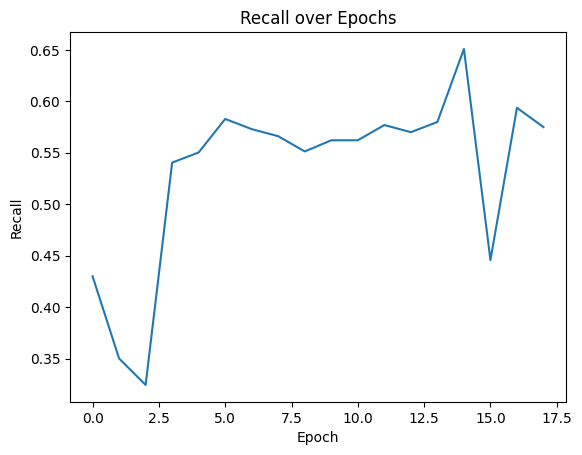

In [ ]:
plt.plot(recall_history)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.show()

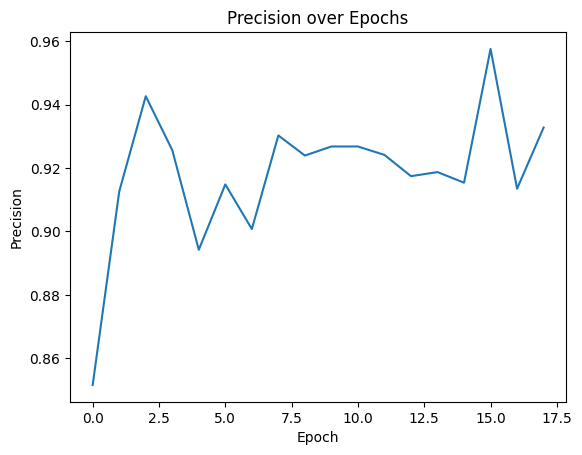

In [ ]:
plt.plot(precision_history)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.show()

In [ ]:
# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
print(model)  # print the model
print("Testing on the test dataset with the best model:")
test_loss, test_accuracy, _, recall, precision = validate_loop(test_loader, model, loss_fn)
print(f"Test Accuracy: {(100*test_accuracy):>0.1f}%, Avg Test loss: {test_loss:>8f}, Recall: {recall}, Precision: {precision}")
print("Done!")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Testing on the test dataset with the best model:
Test Accuracy: 49.0%, Avg Test loss: 1.441261, Recall: 0.606, Precision: 0.9558359621451105
Done!


In [ ]:
# import missing pip package to render graph
%pip install torchviz
from torchviz import make_dot
from IPython.display import Image, display

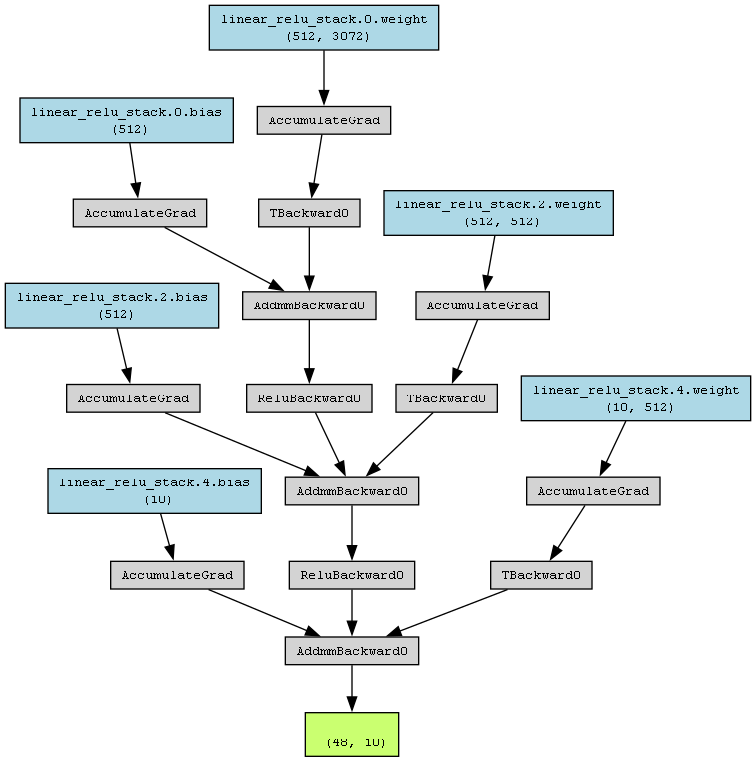

In [ ]:
# creating a graph
graph = make_dot(best_pred, params=dict(model.named_parameters()))
graph.render("model_graph", format="png")

# display a png file in jupyter notebook
display(Image(filename="model_graph.png"))